In [122]:
###import Libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import optimize
from sklearn.linear_model import LinearRegression
import seaborn as sns
from numpy import cos, sin, arcsin, sqrt
from math import radians

In [123]:
###import all relevant datasets and do preliminary cleaning

#import all relevant csv files
traps = pd.read_csv('train.csv')
spray = pd.read_csv('spray1.csv')
weather = pd.read_csv('weather1.csv')

#remove spray values not inside the city of Chicago and drop original index
spray = spray[spray['Longitude'] > -88].reset_index(drop=True) 
spray['Date'] = pd.to_datetime(spray['Date'])

#drop unneeded attributes from weather file
weather.drop(['Depart', 'Cool', 'SnowFall', 'Water1', 'Depth', 'ResultSpeed'], axis='columns', inplace=True)

#average wind speed missing values - filled with mean value
meanVal = weather['AvgSpeed'].mean()
weather['AvgSpeed'].fillna(value=meanVal, inplace=True)
weather['AvgSpeed'] = pd.to_numeric(weather['AvgSpeed'])

#traps df includes multiple rows for the same trap when populations exceed 50. Group all overflow rows into the same row,
MosqSum = traps.groupby(['Address', 'Date', 'Trap', 'WnvPresent'
                         , 'Species', 'Longitude', 'Latitude'])['NumMosquitos'].sum().reset_index()

#create database of locations that found West Nile Virus
WNV = MosqSum[MosqSum['WnvPresent'] == 1]

#add row for coordinates of each weather station from database information
def categorize(row):  
    if row['Station'] == 1:
        return '-87.933'
    return '-87.752'
weather['Long'] = weather.apply(lambda row: categorize(row), axis=1)
def categorise(row):  
    if row['Station'] == 1:
        return '41.995'
    return '41.786'
weather['Lat'] = weather.apply(lambda row: categorise(row), axis=1)

#convert coordinate rows to float to make useable in map
weather['Long'] = pd.to_numeric(weather['Long'])
weather['Lat'] = pd.to_numeric(weather['Lat'])

In [124]:
###use haversine formula to determine which weather station is closest to each mosquito trap

def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r
#manually input the values of the station 1 longitude and latitude into haversine formula and 
#return distance in kilometers from trap

#add distance to each station to mosquito dataframe
MosqSum['Dist_To_Station1'] = MosqSum.apply(lambda row: haversine(-87.933, 41.995, row['Longitude'], row['Latitude']), axis=1)
MosqSum['Dist_To_Station2'] = MosqSum.apply(lambda row: haversine(-87.752, 41.786, row['Longitude'], row['Latitude']), axis=1)
#subtract distance 1 from distance 2. if number is negative, the closest station is station 1, else 2
MosqSum['Dist_diff'] = MosqSum['Dist_To_Station1'].sub(MosqSum['Dist_To_Station2'], axis = 0)
result = []       
for x in MosqSum['Dist_diff']:
    if x < 0:
        result.append(1)
    else:
        result.append(2)
MosqSum['Closest_Station'] = result 

In [125]:
###create individual station dfs with specified rolling averages that can be used in regression calculations
###because traps are only checked around once per week and mosquitoes take 8-10 days from gestation to fully grown adult
###it's necessary to perform rolling averages on weather patterns to isolate correlations.

###mosquitoes are supposed to favor hot, dry conditions, but also lay their eggs in still water. my hypotheses is that
###hot dry days are better for mosquito activity, and extremely wet days help mosquitoes lay eggs

#create dictionary of code meanings to be referenced
CodeDict = {'Haze':'HZ', 'Thunderstorm':'TS', 'Fog':'FG', 'Patches':'BC', 'Smoke':'FU', 'Squall':'SQ' ,'NoLoggedCodes':'NO'}

#create new weather columns that show if weather pattern was present on a given day 
#by extracting all values from CodeSum using dictionary and multiplying by 1 to return int
for x,y in CodeDict.items():
    weather[x] = weather['CodeSum'].str.contains(y)*1
    
Station1 = weather[weather['Station']== 1].reset_index(drop=True)
Station2 = weather[weather['Station']== 2].reset_index(drop=True)

#create list of variables extracted from CodeSum column
Keys = list(CodeDict.keys())
#add variables of interest from weather df that were in their own column instead of CodeSum
Keys.extend(['PrecipTotal', 'Tavg', 'AvgSpeed', 'DewPoint'])

WeatherCon1Day=[]
WeatherCon2Day=[]
WeatherCon3Day=[]
WeatherCon4Day=[]
WeatherCon5Day=[]
WeatherCon6Day=[]
WeatherCon7Day=[]
WeatherCon8Day=[]
WeatherCon9Day=[]
WeatherCon10Day=[]
WeatherCon11Day=[]
WeatherCon12Day=[]
WeatherCon13Day=[]
WeatherCon14Day=[]

WeatherConDict = {1:WeatherCon1Day, 2:WeatherCon2Day, 3:WeatherCon3Day, 4:WeatherCon4Day,
                  5:WeatherCon5Day, 6:WeatherCon6Day, 7:WeatherCon7Day, 8:WeatherCon8Day,
                  9:WeatherCon9Day, 10:WeatherCon10Day, 11:WeatherCon11Day, 12:WeatherCon12Day,
                  13:WeatherCon13Day, 14:WeatherCon14Day}

def rollingfunction(days):
    """creates new rolling mean columns for each station for each item in Keys and new list of columns created"""
    for day in range(1,days):
        for x in Keys:
            Station1[f'Last{day}DayAvg{x}'] = Station1[x].rolling(day).mean()
            Station2[f'Last{day}DayAvg{x}'] = Station2[x].rolling(day).mean()
            WeatherConDict[day].append(f'Last{day}DayAvg{x}')
rollingfunction(15)
WeatherCon = ['Haze','Thunderstorm','Fog','Patches','Smoke','Squall','NoLoggedCodes','PrecipTotal','Tavg','AvgSpeed','DewPoint']
#convert Date values of all columns to be merged to DateTime so that they match
MosqSum['Date'] = pd.to_datetime(MosqSum['Date'])
Station1['Date'] = pd.to_datetime(Station1['Date'])
Station2['Date'] = pd.to_datetime(Station2['Date'])
#recombine stations 1 and 2 into a dataframe that now includes correct previous 10 day averages for individual stations
Combine = [Station1, Station2]
CombinedWeather = pd.concat(Combine).sort_values(['Date'], ascending=True)
#combine mosquito data with weather data based on date and closest weather station
MosqSumStations = pd.merge(MosqSum, CombinedWeather, left_on = ['Closest_Station', 'Date'], right_on = ['Station', 'Date'], how='left')
import warnings
warnings.filterwarnings('ignore')

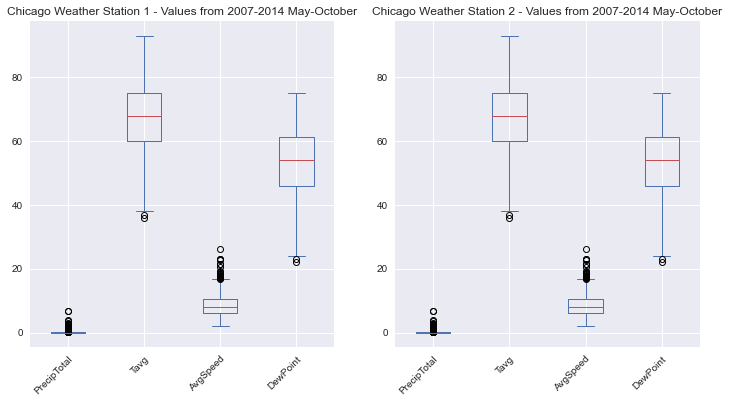

In [126]:
#view range of values for each weather station individually in box plot
sns.set_context('poster')
plt.style.use('seaborn')
fig, (ax1, ax2) =  plt.subplots(1, 2, sharex=False, sharey= False, figsize=(12,6)) 
Station1avg = Station1[['PrecipTotal', 'Tavg', 'AvgSpeed', 'DewPoint']]
Station2avg = Station1[['PrecipTotal', 'Tavg', 'AvgSpeed', 'DewPoint']]
Station1avg.plot(ax=ax1, kind='box', title = 'Chicago Weather Station 1 - Values from 2007-2014 May-October')
Station2avg.plot(ax=ax2, kind='box', title = 'Chicago Weather Station 2 - Values from 2007-2014 May-October')
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.show()

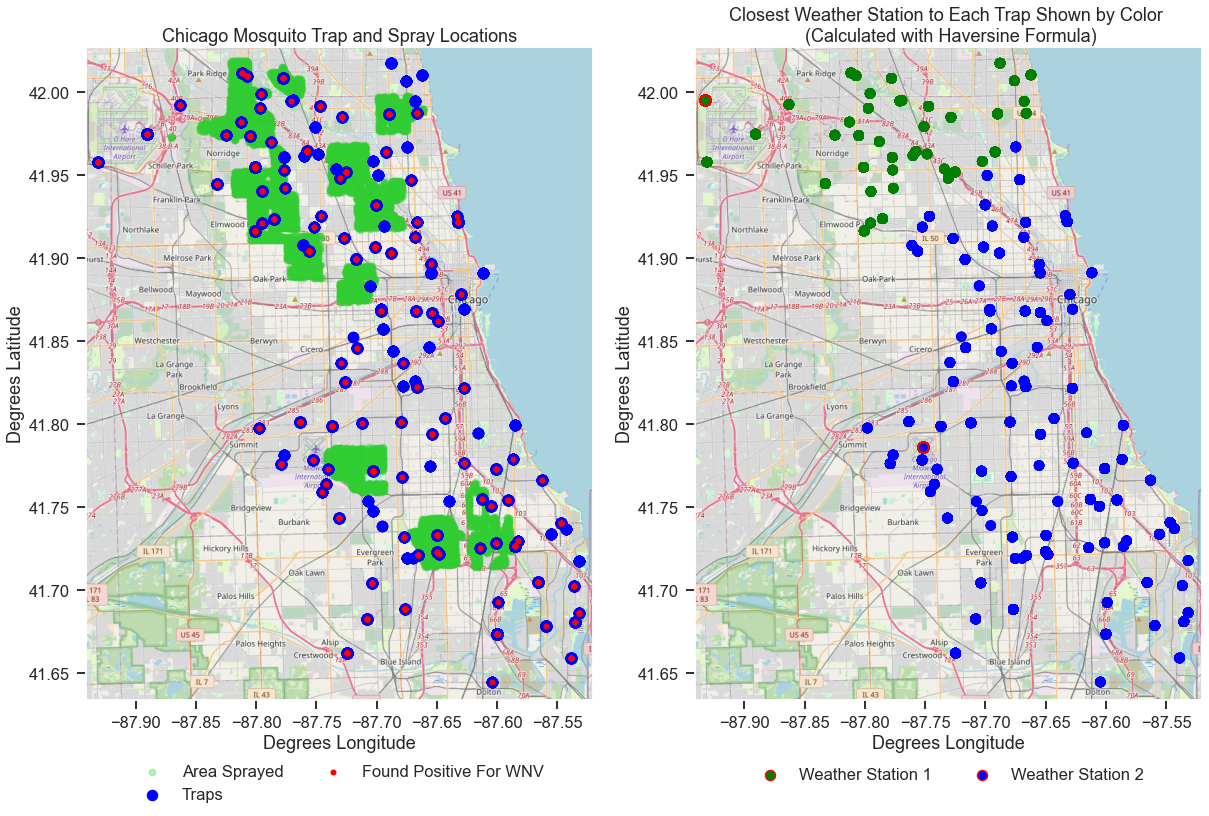

In [127]:
###use station, trap, and spray longitudes and latitudes to visually explore data

#set colors easier to see than black/white and append to respective stations
MosqSumColor = []
for x in MosqSum['Closest_Station']:
    if x == 1: MosqSumColor.append('green')
    else: MosqSumColor.append('blue')
MosqSum['MosqSumColor'] = MosqSumColor

#upload map w/ coordinates .01 degrees larger than min and max longitude and latitude values to ensure all values fit
Dimensions = (-87.9410, -87.5200, 41.6340, 42.0270)
sns.set_context('talk')
Chicago = plt.imread('map (4).png')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,12))
ax1.imshow(Chicago, extent = Dimensions, aspect ='auto')
sns.set_context()

#add spray, traps, WNV positive, and station locations
ax1.scatter(spray.Longitude, spray.Latitude, c='limegreen', alpha = .3, s=40, label='Area Sprayed')
ax1.scatter(traps.Longitude, traps.Latitude, c='b', s=100, label='Traps')
ax1.scatter(WNV.Longitude, WNV.Latitude, c='red', s=20, label='Found Positive For WNV')

#remove grid, add title, and place legend outside box to make legible
ax1.grid(False)
ax1.set_title('Chicago Mosquito Trap and Spray Locations')
ax1.set_xlim(Dimensions[0],Dimensions[1])
ax1.set_ylim(Dimensions[2],Dimensions[3])

#create separate map to show which weather station is the closest
ax2.imshow(Chicago, extent = Dimensions, aspect ='auto')
ax2.scatter(MosqSum.Longitude, MosqSum.Latitude, c=MosqSum.MosqSumColor)
ax2.scatter(Station1.Long, Station1.Lat, c='green', s=100, label='Weather Station 1', edgecolors='red')
ax2.scatter(Station2.Long, Station2.Lat, c='blue', s=100, label='Weather Station 2', edgecolors='red')
ax2.grid(False)
ax2.set_title('Closest Weather Station to Each Trap Shown by Color \n (Calculated with Haversine Formula)')
ax2.set_xlim(Dimensions[0],Dimensions[1])
ax2.set_ylim(Dimensions[2],Dimensions[3])
ax1.legend(bbox_to_anchor=(.5, -.18), loc='lower center', ncol=2)
ax2.legend(bbox_to_anchor=(.5, -.15), loc='lower center', ncol=2)
ax1.set_ylabel('Degrees Latitude')
ax2.set_ylabel('Degrees Latitude')
ax1.set_xlabel('Degrees Longitude')
ax2.set_xlabel('Degrees Longitude')

plt.show()

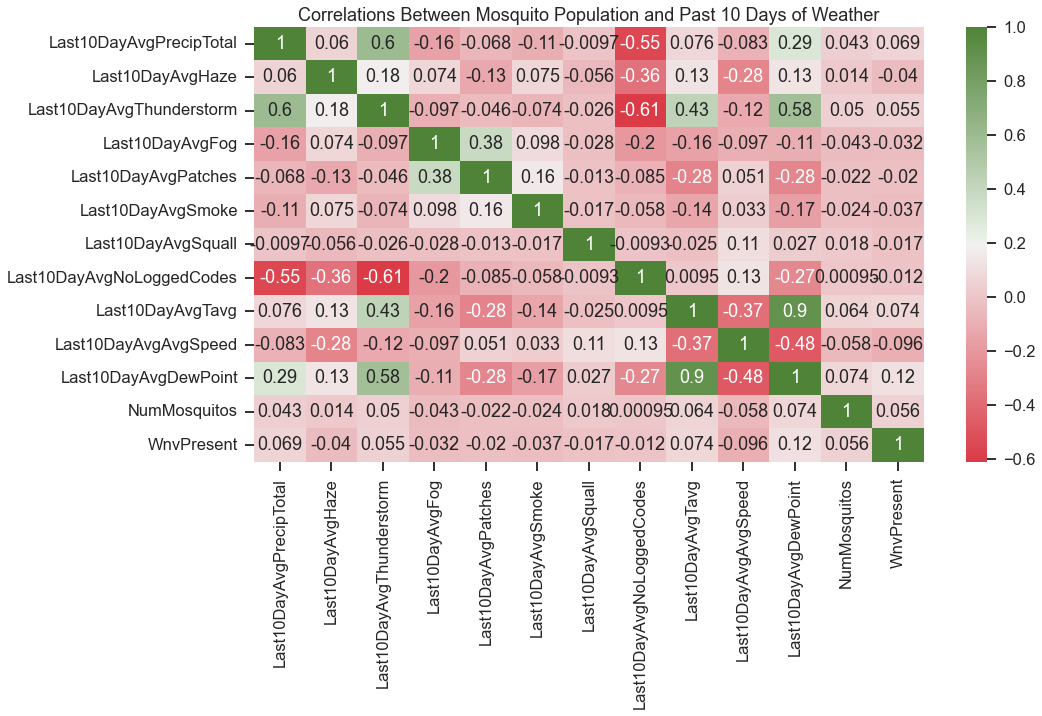

In [97]:
#create heatmap of correlation between values
sns.set_context('talk')
corr = MosqSumStations[['Last10DayAvgPrecipTotal','Last10DayAvgHaze','Last10DayAvgThunderstorm'
                   ,'Last10DayAvgFog','Last10DayAvgPatches','Last10DayAvgSmoke','Last10DayAvgSquall'
                   ,'Last10DayAvgNoLoggedCodes','Last10DayAvgTavg','Last10DayAvgAvgSpeed','Last10DayAvgDewPoint','NumMosquitos', 'WnvPresent']].corr()
plt.figure(figsize = (15,8))
sns.heatmap(corr, cmap=sns.diverging_palette(10, 120, as_cmap=True), annot=True)
plt.title('Correlations Between Mosquito Population and Past 10 Days of Weather')
plt.show()
MosqSumStations.to_csv(r"C:\Users\johnd\Desktop\Excel Files\West Nile\MosquitosAndWeather.csv", index = False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             WnvPresent   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     22.36
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           2.75e-26
Time:                        21:33:08   Log-Likelihood:                 723.82
No. Observations:                8610   AIC:                            -1434.
Df Residuals:                    8603   BIC:                            -1384.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0212      0.030      0.701      0.483      -0.038       0.081
Species_CULEX ERRATICUS           -0.0212      0.195     -0.109      0.913      -0.404       0.361
Species_CULEX PIPIENS              0.0710      0.031      2.320      0.020       0.011       0.131
Species_CULEX PIPIENS/RESTUANS     0.0365      0.030      1.199      0.231      -0.023       0.096
Species_CULEX RESTUANS            -0.0013      0.031     -0.043      0.966      -0.061       0.059
Species_CULEX SALINARIUS          -0.0212      0.037     -0.575      0.566      -0.094       0.051
Species_CULEX TARSALIS            -0.0212      0.084     -0.252      0.801      -0.186       0.144
Species_CULEX TERRITANS           -0.0212      0.033     -0.643      0.520      -0.086       0.043
==============================================================================
Omnibus:                     6687.983   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86611.092
Skew:                           3.892   Prob(JB):                         0.00
Kurtosis:                      16.447   Cond. No.                     3.78e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.14e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

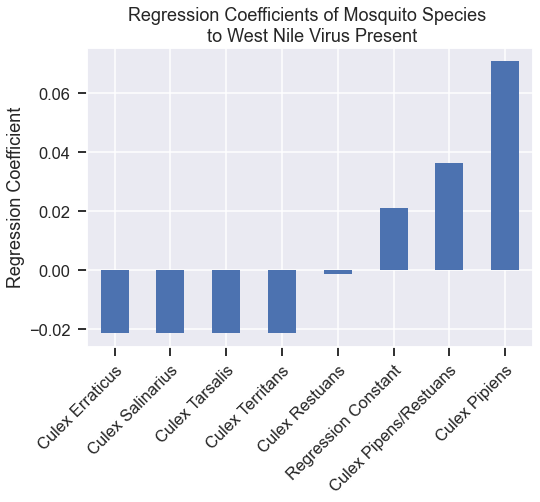

In [98]:
###explore mosquito species data to inspect for possible correlations. 
###its assumed that one species causes more cases than others

#split up species column into individual columns of binary results using pd.get_dummies
MosqSumStationsSpec = pd.get_dummies(MosqSumStations, columns = ['Species'])
#create chart of highest west nile virus regression coefficient per species
dep_varSpec = MosqSumStationsSpec[['WnvPresent']]
indep_varsSpec = MosqSumStationsSpec[['Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS','Species_CULEX TARSALIS', 'Species_CULEX TERRITANS']]
indep_vars_cSpec = sm.add_constant(indep_varsSpec)
regression_modelSpec = sm.OLS(dep_varSpec, indep_vars_cSpec).fit()
fig, ax7 = plt.subplots()
regression_modelSpec.params.sort_values().plot(kind='bar')
plt.title('Regression Coefficients of Mosquito Species \n to West Nile Virus Present')
ax7.set_xticklabels(['Culex Erraticus', 'Culex Salinarius', 'Culex Tarsalis','Culex Territans', 'Culex Restuans', 'Regression Constant','Culex Pipens/Restuans', 'Culex Pipiens'])
plt.setp(ax7.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Regression Coefficient')
regression_modelSpec.summary()

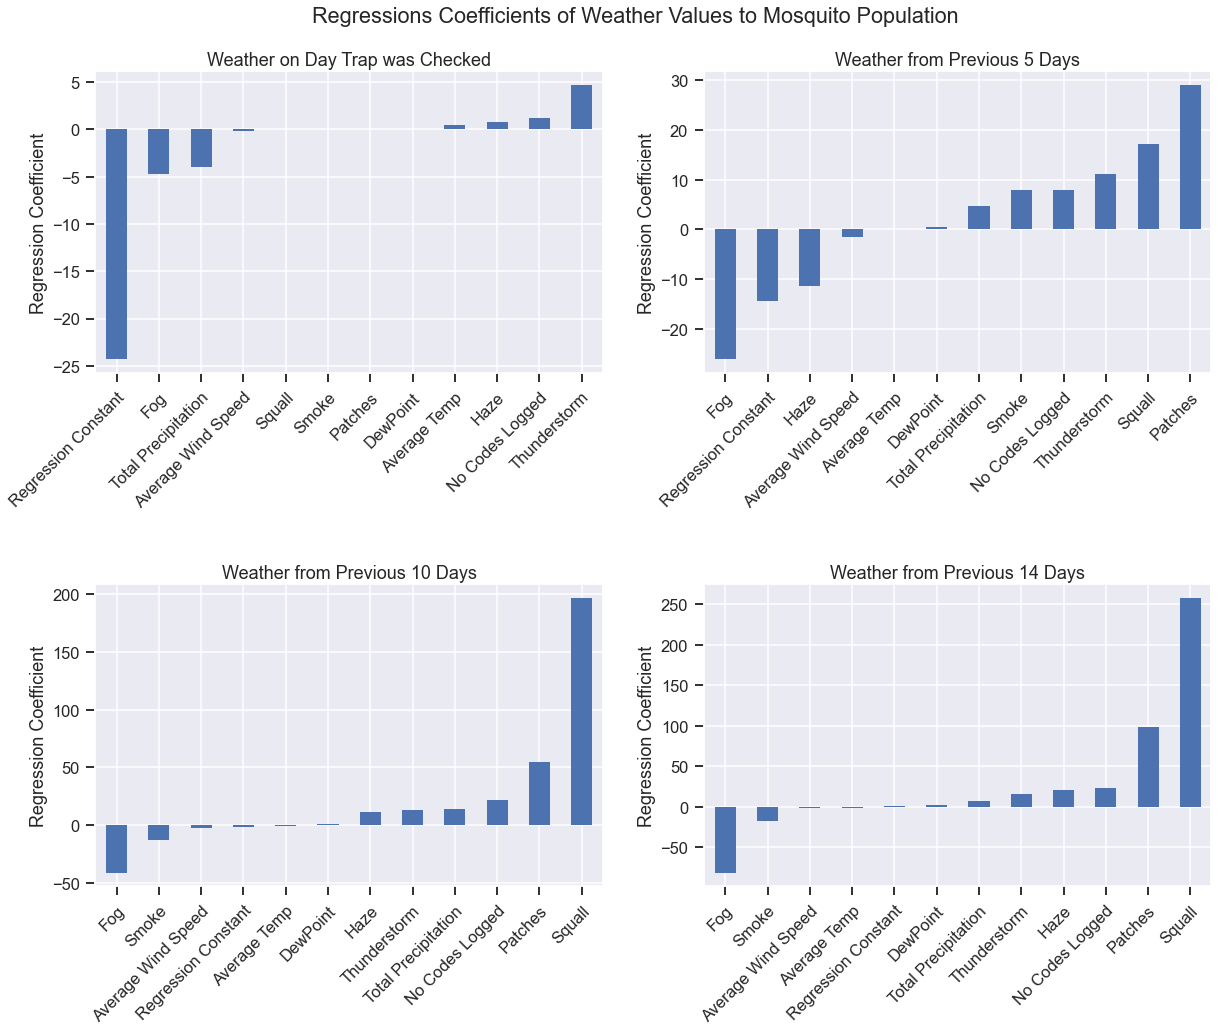

In [109]:
###explore rolling weather data to see if correlations exist

#create rolling weather data for current day, 5 day, 10 day, and 14 day rolling averages as dependent variable
#using mosquito population as independent variable
#add regression constant to compare to other variables
dep_var1 = MosqSumStations[['NumMosquitos']]
indep_vars1 = MosqSumStations[WeatherCon]
indep_vars_c1 = sm.add_constant(indep_vars1)
regression_modelcurr = sm.OLS(dep_var1, indep_vars_c1).fit()

dep_var2 = MosqSumStations[['NumMosquitos']]
indep_vars2 = MosqSumStations[WeatherCon5Day]
indep_vars_c2 = sm.add_constant(indep_vars2)
regression_modelFiveDay = sm.OLS(dep_var2, indep_vars_c2).fit()

dep_var3 = MosqSumStations[['NumMosquitos']]
indep_vars3 = MosqSumStations[WeatherCon10Day]
indep_vars_c3 = sm.add_constant(indep_vars3)
regression_modelTenDay = sm.OLS(dep_var3, indep_vars_c3).fit()

dep_var4 = MosqSumStations[['NumMosquitos']]
indep_vars4 = MosqSumStations[WeatherCon14Day]
indep_vars_c4 = sm.add_constant(indep_vars4)
regression_modelFourteenDay = sm.OLS(dep_var4, indep_vars_c4).fit()

sns.set_context('talk')

#regression models to DataFrames that can be plotted
CurrReg = pd.DataFrame(data=regression_modelcurr.params.sort_values())
FiveDayReg = pd.DataFrame(data=regression_modelFiveDay.params.sort_values())
TenDayReg = pd.DataFrame(data=regression_modelTenDay.params.sort_values())
FourteenDayReg = pd.DataFrame(data=regression_modelFourteenDay.params.sort_values())

#plotting all charts together
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(20,15))

#labeling individual charts
CurrReg[0].plot.bar(ax=ax1, title='Weather on Day Trap was Checked')
FiveDayReg[0].plot.bar(ax=ax2, title='Weather from Previous 5 Days')
TenDayReg[0].plot.bar(ax=ax3, title='Weather from Previous 10 Days')
FourteenDayReg[0].plot.bar(ax=ax4, title='Weather from Previous 14 Days')

#change x tick labels for readability after value orders are found
ax1.set_xticklabels(['Regression Constant', 'Fog', 'Total Precipitation', 'Average Wind Speed', 'Squall'
                              , 'Smoke', 'Patches', 'DewPoint', 'Average Temp', 'Haze'
                              , 'No Codes Logged', 'Thunderstorm'])
ax2.set_xticklabels(['Fog', 'Regression Constant','Haze', 'Average Wind Speed'
                     , 'Average Temp', 'DewPoint', 'Total Precipitation', 'Smoke', 'No Codes Logged', 'Thunderstorm', 'Squall', 'Patches'])
ax3.set_xticklabels(['Fog', 'Smoke', 'Average Wind Speed', 'Regression Constant', 'Average Temp', 'DewPoint','Haze'
                     , 'Thunderstorm', 'Total Precipitation', 'No Codes Logged', 'Patches', 'Squall'])
ax4.set_xticklabels(['Fog', 'Smoke', 'Average Wind Speed', 'Average Temp', 'Regression Constant', 'DewPoint'
                    , 'Total Precipitation', 'Thunderstorm','Haze', 'No Codes Logged', 'Patches', 'Squall'])

#rotate labels 45 degrees for increased readability and anchor to ticks
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax4.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)

#set overall plot title
plt.suptitle('Regressions Coefficients of Weather Values to Mosquito Population', y=.94)
plt.subplots_adjust(hspace=.7)

#label y-axis
ax1.set_ylabel('Regression Coefficient')
ax2.set_ylabel('Regression Coefficient')
ax3.set_ylabel('Regression Coefficient')
ax4.set_ylabel('Regression Coefficient')
plt.show()

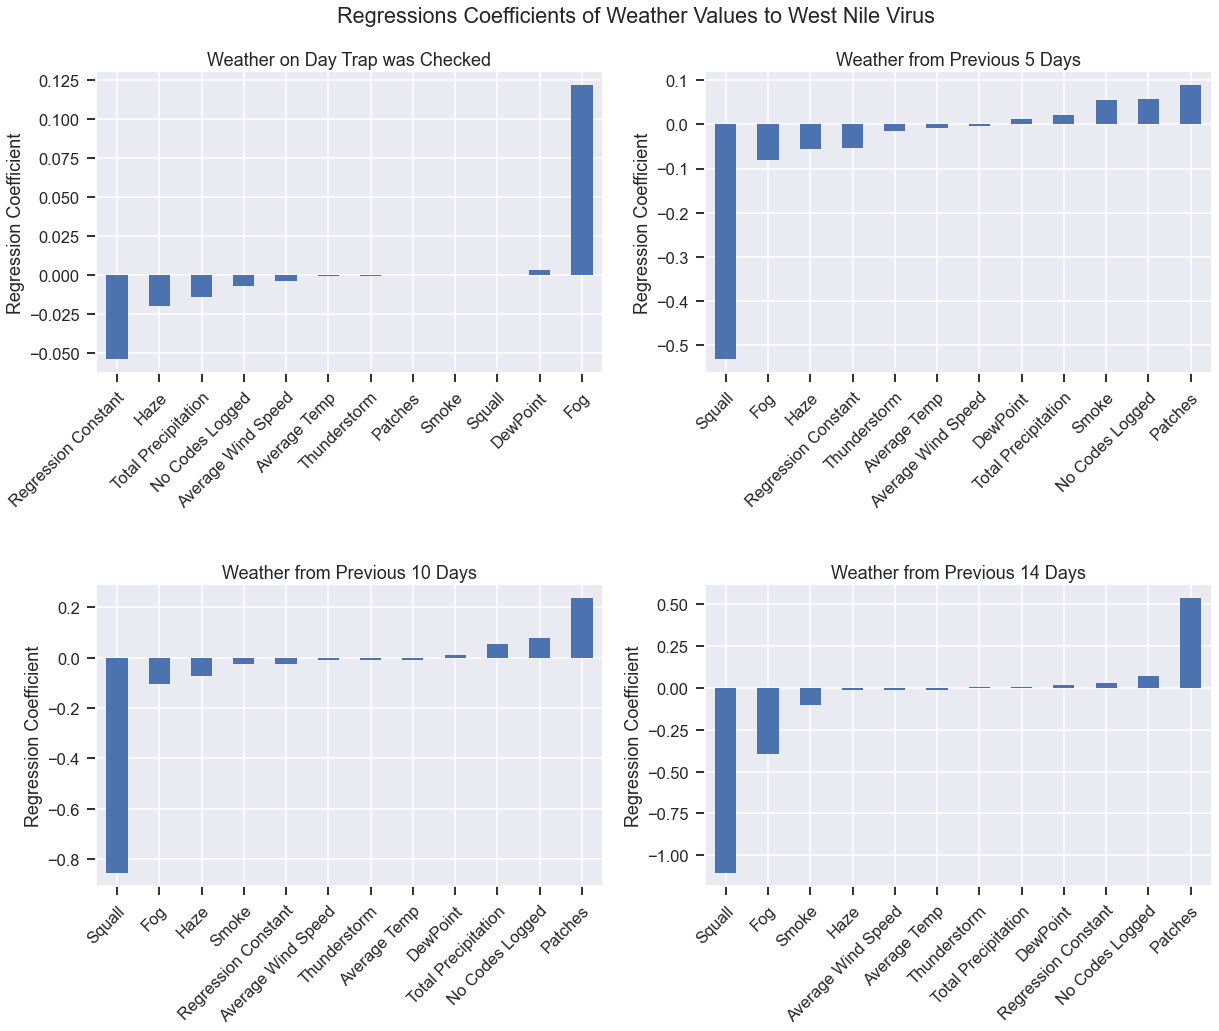

In [110]:
###do the same thing with weather values to West Nile Virus

dep_var5  = MosqSumStations[['WnvPresent']]
regression_modelcurrWNV = sm.OLS(dep_var5, indep_vars_c1).fit()

dep_var6 = MosqSumStations[['WnvPresent']]
regression_modelFiveDayWNV = sm.OLS(dep_var6, indep_vars_c2).fit()

dep_var7 = MosqSumStations[['WnvPresent']]
regression_modelTenDayWNV = sm.OLS(dep_var7, indep_vars_c3).fit()

dep_var8 = MosqSumStations[['WnvPresent']]
regression_modelFourteenDayWNV = sm.OLS(dep_var8, indep_vars_c4).fit()

CurrRegWNV = pd.DataFrame(data=regression_modelcurrWNV.params.sort_values())
FiveDayRegWNV = pd.DataFrame(data=regression_modelFiveDayWNV.params.sort_values())
TenDayRegWNV = pd.DataFrame(data=regression_modelTenDayWNV.params.sort_values())
FourteenDayRegWNV = pd.DataFrame(data=regression_modelFourteenDayWNV.params.sort_values())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(20,15))

CurrRegWNV[0].plot.bar(ax=ax1, title='Weather on Day Trap was Checked')
FiveDayRegWNV[0].plot.bar(ax=ax2, title='Weather from Previous 5 Days')
TenDayRegWNV[0].plot.bar(ax=ax3, title='Weather from Previous 10 Days')
FourteenDayRegWNV[0].plot.bar(ax=ax4, title='Weather from Previous 14 Days')
ax1.set_xticklabels(['Regression Constant', 'Haze', 'Total Precipitation', 'No Codes Logged', 'Average Wind Speed', 'Average Temp'
                     , 'Thunderstorm', 'Patches', 'Smoke', 'Squall', 'DewPoint', 'Fog'])
ax2.set_xticklabels(['Squall','Fog','Haze', 'Regression Constant', 'Thunderstorm', 'Average Temp', 'Average Wind Speed'
                     , 'DewPoint', 'Total Precipitation', 'Smoke', 'No Codes Logged','Patches'])
ax3.set_xticklabels(['Squall','Fog','Haze', 'Smoke', 'Regression Constant', 'Average Wind Speed', 'Thunderstorm', 'Average Temp'
                     , 'DewPoint', 'Total Precipitation', 'No Codes Logged','Patches'])
ax4.set_xticklabels(['Squall','Fog', 'Smoke','Haze', 'Average Wind Speed', 'Average Temp', 'Thunderstorm'
                     , 'Total Precipitation', 'DewPoint', 'Regression Constant', 'No Codes Logged','Patches'])
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.setp(ax4.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
plt.suptitle('Regressions Coefficients of Weather Values to West Nile Virus', y=.94)
plt.subplots_adjust(hspace=.7)
ax1.set_ylabel('Regression Coefficient')
ax2.set_ylabel('Regression Coefficient')
ax3.set_ylabel('Regression Coefficient')
ax4.set_ylabel('Regression Coefficient')
plt.show()

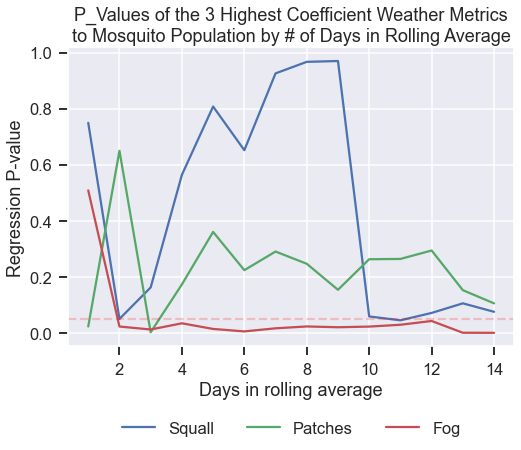

In [111]:
###identifying P-values over each day to see when the top 3 regression coefficients were statistically significant

#create empty lists where all P-values can be appended
MosqPconst = []
MosqPHaze = []
MosqPThunderstorm = []
MosqPFog  = []
MosqPPatches = []
MosqPSmoke = []
MosqPSquall = []
MosqPNoLoggedCodes = []
MosqPPrecipTotal = []
MosqPTavg = []
MosqPAvgSpeed = []
MosqPDewPoint = []

#create dependent and independent variables, extract P-values from regression_model.summary2()
#append extracted P-values to respective list
for x in WeatherConDict:
    dep_var1 = MosqSumStations[['NumMosquitos']]
    indep_vars1 = MosqSumStations[WeatherConDict[x]]
    indep_vars_c1 = sm.add_constant(indep_vars1)
    regression_model = sm.OLS(dep_var1, indep_vars_c1).fit()
    p_values = regression_model.summary2().tables[1]['P>|t|']
    MosqPconst.append(p_values[0])
    MosqPHaze.append(p_values[1])
    MosqPThunderstorm.append(p_values[2])
    MosqPFog.append(p_values[3])
    MosqPPatches.append(p_values[4])
    MosqPSmoke.append(p_values[5])
    MosqPSquall.append(p_values[6])
    MosqPNoLoggedCodes.append(p_values[7])
    MosqPPrecipTotal.append(p_values[8])
    MosqPTavg.append(p_values[9])
    MosqPAvgSpeed.append(p_values[10])
    MosqPDewPoint.append(p_values[11])
    
#create a dataframe out of lists of P-values where columns are weather metrics and rows are # of days in rolling average
MosqPValDF = pd.DataFrame(list(zip(MosqPconst,MosqPHaze,MosqPThunderstorm,MosqPFog,MosqPPatches,MosqPSmoke,MosqPSquall
                                    ,MosqPNoLoggedCodes,MosqPPrecipTotal,MosqPTavg,MosqPAvgSpeed,MosqPDewPoint)),
                      columns = ['const','Haze','Thunderstorm','Fog','Patches','Smoke','Squall'
                                    ,'NoLoggedCodes','PrecipTotal','Tavg','AvgSpeed','DewPoint'])
MosqPValDF['Days']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]

#plot P values of the 3 highest regression coefficients
plt.plot(MosqPValDF['Days'], MosqPValDF['Squall'], label='Squall')
plt.plot(MosqPValDF['Days'], MosqPValDF['Patches'], label='Patches')
plt.plot(MosqPValDF['Days'], MosqPValDF['Fog'], label='Fog')
plt.legend(bbox_to_anchor=(.5,-.35), loc='lower center', ncol=3)
#add horizontal line showing the threshold of statistical significance
plt.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
plt.ylabel('Regression P-value')
plt.xlabel('Days in rolling average')
plt.title('P_Values of the 3 Highest Coefficient Weather Metrics\nto Mosquito Population by # of Days in Rolling Average')
plt.show()

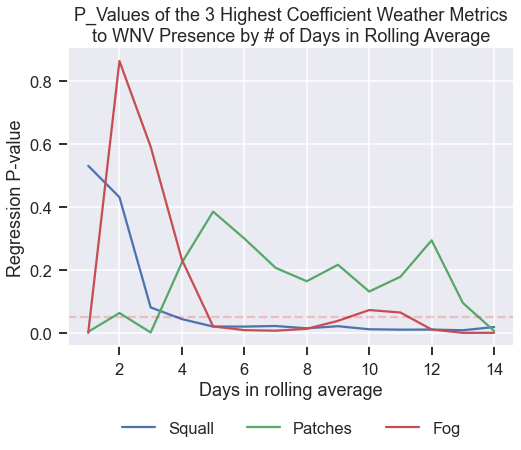

In [112]:
#do the same thing for west nile virus presence as above.
WNVPconst = []
WNVPHaze = []
WNVPThunderstorm = []
WNVPFog  = []
WNVPPatches = []
WNVPSmoke = []
WNVPSquall = []
WNVPNoLoggedCodes = []
WNVPPrecipTotal = []
WNVPTavg = []
WNVPAvgSpeed = []
WNVPDewPoint = []
for x in WeatherConDict:
    dep_var1 = MosqSumStations[['WnvPresent']]
    indep_vars1 = MosqSumStations[WeatherConDict[x]]
    indep_vars_c1 = sm.add_constant(indep_vars1)
    regression_model = sm.OLS(dep_var1, indep_vars_c1).fit()
    p_values = regression_model.summary2().tables[1]['P>|t|']
    WNVPconst.append(p_values[0])
    WNVPHaze.append(p_values[1])
    WNVPThunderstorm.append(p_values[2])
    WNVPFog.append(p_values[3])
    WNVPPatches.append(p_values[4])
    WNVPSmoke.append(p_values[5])
    WNVPSquall.append(p_values[6])
    WNVPNoLoggedCodes.append(p_values[7])
    WNVPPrecipTotal.append(p_values[8])
    WNVPTavg.append(p_values[9])
    WNVPAvgSpeed.append(p_values[10])
    WNVPDewPoint.append(p_values[11])
WNVPValDF = pd.DataFrame(list(zip(WNVPconst,WNVPHaze,WNVPThunderstorm,WNVPFog,WNVPPatches,WNVPSmoke,WNVPSquall
                                    ,WNVPNoLoggedCodes,WNVPPrecipTotal,WNVPTavg,WNVPAvgSpeed,WNVPDewPoint)),
                      columns = ['const','Haze','Thunderstorm','Fog','Patches','Smoke','Squall'
                                    ,'NoLoggedCodes','PrecipTotal','Tavg','AvgSpeed','DewPoint'])
WNVPValDF['Days']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
plt.plot(WNVPValDF['Days'], WNVPValDF['Squall'], label='Squall')
plt.plot(WNVPValDF['Days'], WNVPValDF['Patches'], label='Patches')
plt.plot(WNVPValDF['Days'], WNVPValDF['Fog'], label='Fog')

plt.legend(bbox_to_anchor=(.5,-.35), loc='lower center', ncol=3)
plt.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
plt.ylabel('Regression P-value')
plt.xlabel('Days in rolling average')
plt.title('P_Values of the 3 Highest Coefficient Weather Metrics\nto WNV Presence by # of Days in Rolling Average')
plt.show()

,Spray,Date,Latitude,Longitude
0,1,2011-09-07,41.974329,-87.795839
1,2,2011-09-07,41.989614,-87.807633
2,3,2011-09-07,41.980202,-87.821025
3,4,2013-07-17,42.007016,-87.777532
4,5,2013-07-17,41.736556,-87.649607


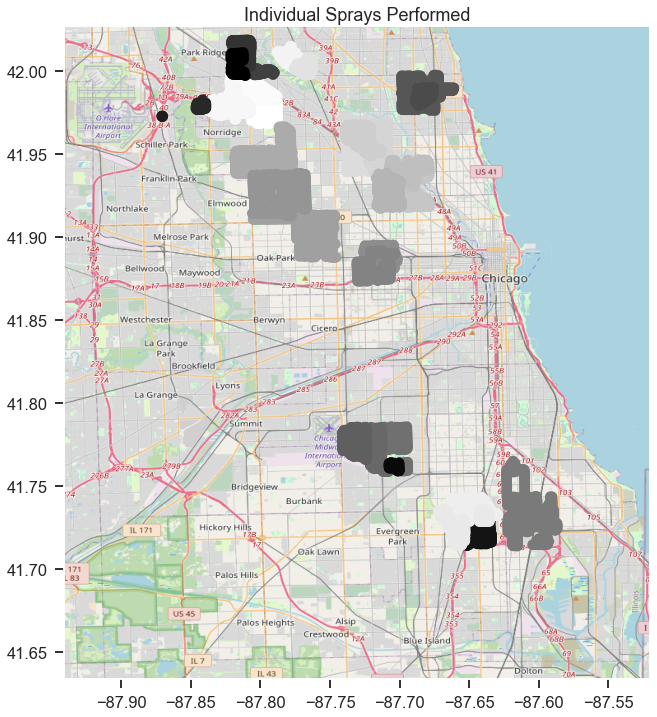

In [114]:
###Show locations of the 31 individual sprays (some overlapping days)

Dimensions = (-87.9410, -87.5200, 41.6340, 42.0270)
sns.set_context('talk')
Chicago = plt.imread('map (4).png')
fig, ax = plt.subplots(figsize = (10.5,12))
ax.imshow(Chicago, extent = Dimensions, aspect ='auto')
sns.set_context()

#color mosquito traps by which station is closer
ax.scatter(spray.Longitude, spray.Latitude, c=spray.Spray)
ax.grid(False)
ax.set_title('Individual Sprays Performed')
ax.set_xlim(Dimensions[0],Dimensions[1])
ax.set_ylim(Dimensions[2],Dimensions[3])
plt.show()

In [158]:
#save only needed mosquito values to new df
Mosquito = MosqSum[['Date', 'WnvPresent', 'NumMosquitos', 'Latitude', 'Longitude']]
Mosquito = Mosquito.sort_values(by='Date').reset_index(drop=True)

In [329]:
###This code cross references each individual trap check to see if it has had a spray within 1km & within the last x days
from datetime import timedelta
SprayDurations = {10:'hasSprayList10', 20:'hasSprayList20', 30:'hasSprayList30'}
SprayDistance = [.1,.25,.5, 1, 2]
for z in SprayDistance:        
    for x,y in SprayDurations.items():
        y = []
        for trap in Mosquito.iterrows():
            mosquito_lat = trap[1][3]
            mosquito_long = trap[1][4]
            time_range_end = trap[1][0]
            time_range_start = time_range_end - timedelta(x)

            sprays_for_date = spray[(time_range_start < spray['Date']) & (spray['Date'] < time_range_end)]
            hasSpray = 0
            for s in sprays_for_date.iterrows():
                spray_lat = s[1][2]
                spray_long = s[1][3]
                h = haversine(mosquito_lat, mosquito_long, spray_lat, spray_long)

                if h <= z:
                    hasSpray = 1
                    break
            y.append(hasSpray)
        Mosquito[f'HasSpray{x}within{z}km'] = y
    

In [335]:
Mosquito

,Date,WnvPresent,NumMosquitos,Latitude,Longitude,HasSpray10within0.1km,HasSpray20within0.1km,HasSpray30within0.1km,HasSpray10within0.25km,HasSpray20within0.25km,HasSpray30within0.25km,HasSpray10within0.5km,HasSpray20within0.5km,HasSpray30within0.5km,HasSpray10within1km,HasSpray20within1km,HasSpray30within1km,HasSpray10within2km,HasSpray20within2km,HasSpray30within2km
0,2007-05-29,0,2,41.867108,-87.654224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,0,1,41.891118,-87.654491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,0,1,41.919343,-87.694259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2007-05-29,0,1,41.896282,-87.655232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2007-05-29,0,2,41.921965,-87.632085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605,2013-09-26,0,37,41.974689,-87.890615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8606,2013-09-26,0,4,41.974689,-87.890615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8607,2013-09-26,1,39,41.974689,-87.890615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8608,2013-09-26,0,2,41.878114,-87.629798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [337]:


SprayDistancesAndDurations = {'HasSpray10within0.1km':'Spray Within 10 Days and .1km'
                              ,'HasSpray20within0.1km':'Spray Within 20 Days and .1km'
                              ,'HasSpray30within0.1km':'Spray Within 30 Days and .1km'
                              ,'HasSpray10within0.25km':'Spray Within 10 Days and .25km'
                              ,'HasSpray20within0.25km':'Spray Within 20 Days and .25km'
                              ,'HasSpray30within0.25km':'Spray Within 30 Days and .25km'
                              ,'HasSpray10within0.5km':'Spray Within 10 Days and .5km'
                              ,'HasSpray20within0.5km':'Spray Within 20 Days and .5km'
                              ,'HasSpray30within0.5km':'Spray Within 30 Days and .5km'
                              ,'HasSpray10within1km':'Spray Within 10 Days and 1km'
                              ,'HasSpray20within1km':'Spray Within 20 Days and 1km'
                              ,'HasSpray30within1km':'Spray Within 30 Days and 1km'
                              ,'HasSpray10within2km':'Spray Within 10 Days and 2km'
                              ,'HasSpray20within2km':'Spray Within 20 Days and 2km'
                              ,'HasSpray30within2km':'Spray Within 30 Days and 2km'}
SprayDistancesAndDurationsValues = ['Regression Constant']
for x,y in SprayDistancesAndDurations.items():
    SprayDistancesAndDurationsValues.append(y)
    
Mosquito2013 = Mosquito[Mosquito['Date'] > '2013-01-01']
Mosquito2013

,Date,WnvPresent,NumMosquitos,Latitude,Longitude,HasSpray10within0.1km,HasSpray20within0.1km,HasSpray30within0.1km,HasSpray10within0.25km,HasSpray20within0.25km,HasSpray30within0.25km,HasSpray10within0.5km,HasSpray20within0.5km,HasSpray30within0.5km,HasSpray10within1km,HasSpray20within1km,HasSpray30within1km,HasSpray10within2km,HasSpray20within2km,HasSpray30within2km
6552,2013-06-07,0,11,41.992478,-87.862995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6553,2013-06-07,0,5,41.992478,-87.862995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6554,2013-06-07,0,7,41.801179,-87.679447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6555,2013-06-07,0,1,41.984809,-87.728492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6556,2013-06-07,0,1,41.801498,-87.763416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605,2013-09-26,0,37,41.974689,-87.890615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8606,2013-09-26,0,4,41.974689,-87.890615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8607,2013-09-26,1,39,41.974689,-87.890615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8608,2013-09-26,0,2,41.878114,-87.629798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.1, 'Effects of Pesticide Spraying on Mosquito Population in Chicago Across All Years Measured')

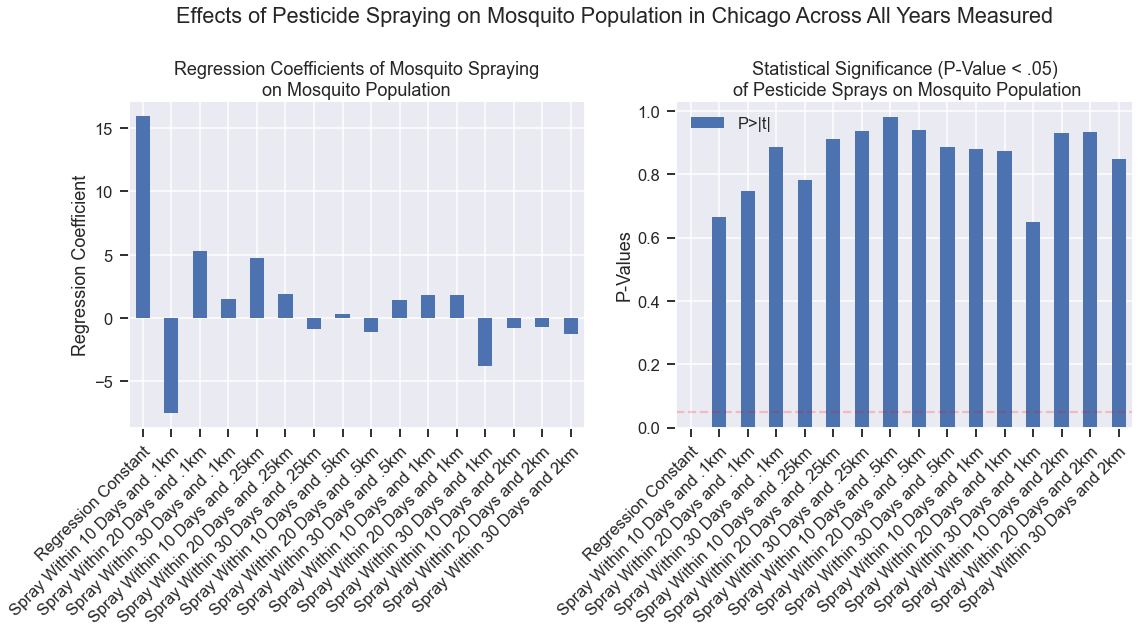

In [354]:
dep_varSpray = Mosquito[['NumMosquitos']]
indep_varsSpray = Mosquito[SprayDistancesAndDurations.keys()]
indep_vars_cSpray = sm.add_constant(indep_varsSpray)
regression_modelSpray = sm.OLS(dep_varSpray, indep_vars_cSpray).fit()
Sprayp_values = regression_modelSpray.summary2().tables[1]['P>|t|']
Sprayp_valuesdf = pd.DataFrame(Sprayp_values)

fig, (ax8,ax11) = plt.subplots(1, 2, sharex=False, sharey= False, figsize=(18,6)) 
regression_modelSpray.params.plot(ax=ax8, kind='bar', title = 'Regression Coefficients of Mosquito Spraying\non Mosquito Population')
ax8.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax8.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax8.set_ylabel('Regression Coefficient')

Sprayp_valuesdf.plot(ax=ax11, kind='bar', title = 'Statistical Significance (P-Value < .05)\n of Pesticide Sprays on Mosquito Population')
ax11.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax11.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
ax11.set_ylabel('P-Values')
plt.suptitle('Effects of Pesticide Spraying on Mosquito Population in Chicago Across All Years Measured', y=1.1)

Text(0.5, 1.1, 'Effects of Pesticide Spraying on Mosquito Population in Chicago in 2013')

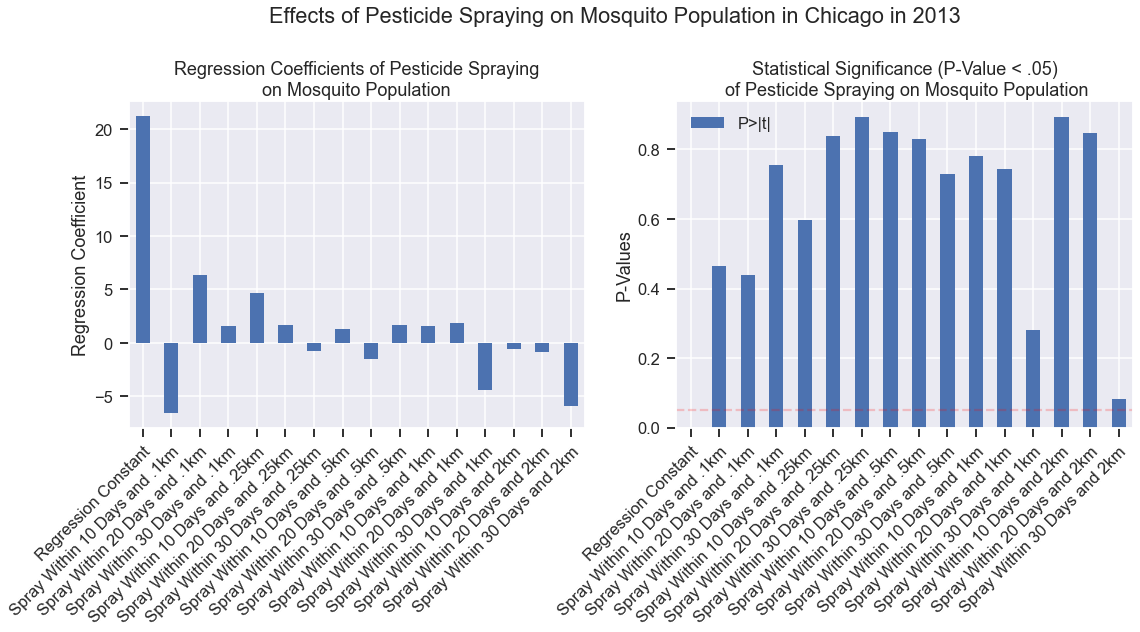

In [353]:
dep_varSpray = Mosquito2013[['NumMosquitos']]
indep_varsSpray = Mosquito2013[SprayDistancesAndDurations.keys()]
indep_vars_cSpray = sm.add_constant(indep_varsSpray)
regression_modelSpray = sm.OLS(dep_varSpray, indep_vars_cSpray).fit()
Sprayp_values = regression_modelSpray.summary2().tables[1]['P>|t|']
Sprayp_valuesdf = pd.DataFrame(Sprayp_values)

fig, (ax8,ax11) = plt.subplots(1, 2, sharex=False, sharey= False, figsize=(18,6)) 
regression_modelSpray.params.plot(ax=ax8, kind='bar', title = 'Regression Coefficients of Pesticide Spraying\non Mosquito Population')
ax8.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax8.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax8.set_ylabel('Regression Coefficient')

Sprayp_valuesdf.plot(ax=ax11, kind='bar', title = 'Statistical Significance (P-Value < .05)\n of Pesticide Spraying on Mosquito Population')
ax11.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax11.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
ax11.set_ylabel('P-Values')
plt.suptitle('Effects of Pesticide Spraying on Mosquito Population in Chicago in 2013', y=1.1)

Text(0.5, 1.1, 'Effects of Pesticide Spraying on West Nile Virus Prevalence in Chicago Across All Years Measured')

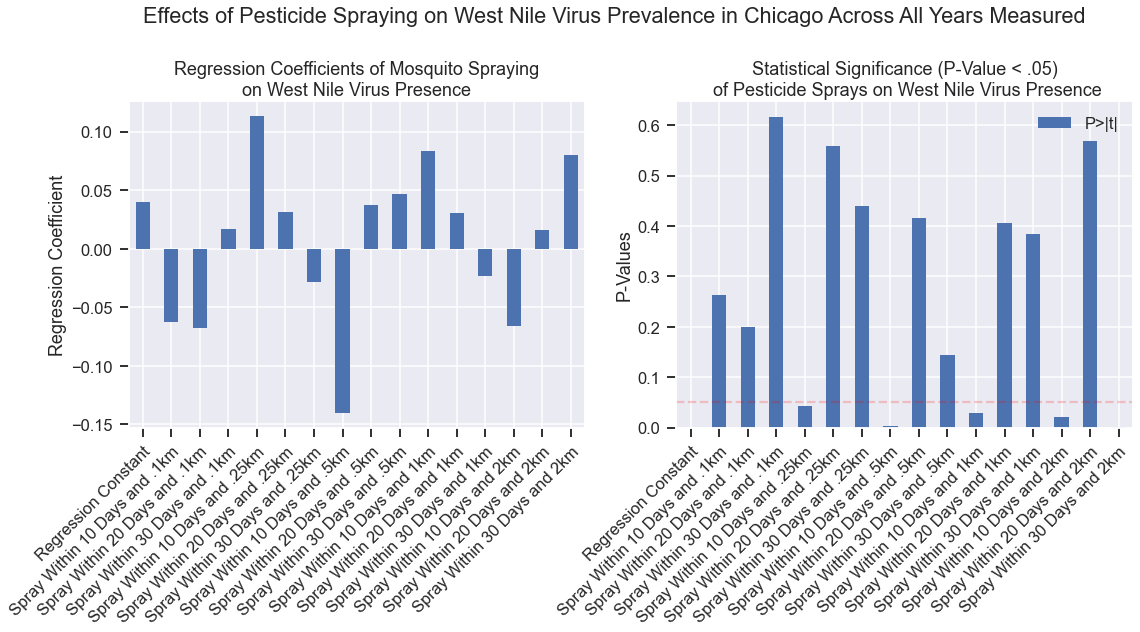

In [355]:
dep_varSprayWNV = Mosquito[['WnvPresent']]
indep_varsSprayWNV = Mosquito[SprayDistancesAndDurations.keys()]
indep_vars_cSprayWNV = sm.add_constant(indep_varsSprayWNV)
regression_modelSprayWNV = sm.OLS(dep_varSprayWNV, indep_vars_cSprayWNV).fit()
SprayWNVp_values = regression_modelSprayWNV.summary2().tables[1]['P>|t|']
SprayWNVp_valuesdf = pd.DataFrame(SprayWNVp_values)

fig, (ax9,ax10) = plt.subplots(1, 2, sharex=False, sharey= False, figsize=(18,6)) 
regression_modelSprayWNV.params.plot(ax=ax9, kind='bar', title = 'Regression Coefficients of Mosquito Spraying\non West Nile Virus Presence')
ax9.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax9.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax9.set_ylabel('Regression Coefficient')

SprayWNVp_valuesdf.plot(ax=ax10, kind='bar', title = 'Statistical Significance (P-Value < .05)\n of Pesticide Sprays on West Nile Virus Presence')
ax10.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax10.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
ax10.set_ylabel('P-Values')
plt.suptitle('Effects of Pesticide Spraying on West Nile Virus Prevalence in Chicago Across All Years Measured', y=1.1)

Text(0.5, 1.1, 'Effects of Pesticide Spraying on West Nile Virus Prevalence in Chicago in 2013')

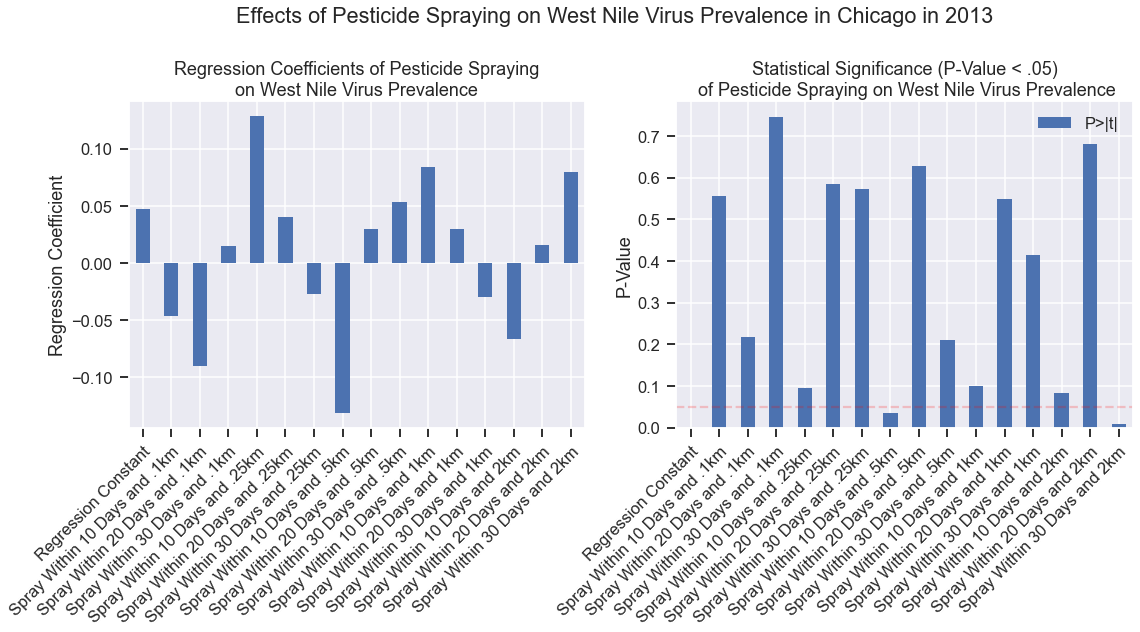

In [352]:
dep_varSprayWNV = Mosquito2013[['WnvPresent']]
indep_varsSprayWNV = Mosquito2013[SprayDistancesAndDurations.keys()]
indep_vars_cSprayWNV = sm.add_constant(indep_varsSprayWNV)
regression_modelSprayWNV = sm.OLS(dep_varSprayWNV, indep_vars_cSprayWNV).fit()
SprayWNVp_values = regression_modelSprayWNV.summary2().tables[1]['P>|t|']
SprayWNVp_valuesdf = pd.DataFrame(SprayWNVp_values)

fig, (ax9,ax10) = plt.subplots(1, 2, sharex=False, sharey= False, figsize=(18,6)) 
regression_modelSprayWNV.params.plot(ax=ax9, kind='bar', title = 'Regression Coefficients of Pesticide Spraying\non West Nile Virus Prevalence')
ax9.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax9.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax9.set_ylabel('Regression Coefficient')

SprayWNVp_valuesdf.plot(ax=ax10, kind='bar', title = 'Statistical Significance (P-Value < .05)\n of Pesticide Spraying on West Nile Virus Prevalence')
ax10.set_xticklabels(SprayDistancesAndDurationsValues)
plt.setp(ax10.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.axhline(y=0.05, color='r', linestyle='--', alpha=.2)
ax10.set_ylabel('P-Value')
plt.suptitle('Effects of Pesticide Spraying on West Nile Virus Prevalence in Chicago in 2013', y=1.1)